# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [17]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [34]:
### Replace each question mark with the appropriate value.
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
# See numpy.unique : https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html
unique_items, counts = np.unique(y_train, return_counts=True) 
n_classes = len(counts)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 31367
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

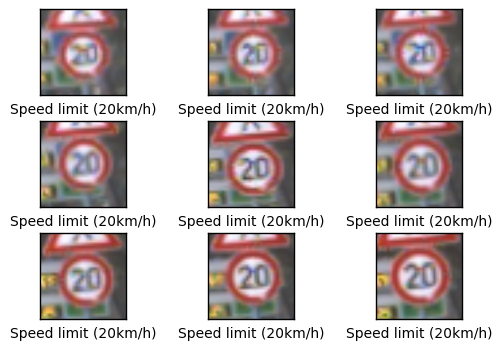

In [3]:
### Data exploration visualization goes here.
import matplotlib.pyplot as plt
import csv
# Visualizations will be shown in the notebook.
%matplotlib inline

# Create figure with 3x3 sub-plots.
def plot_images(images, classes, labels, gray):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        if(gray):
            ax.imshow(images[i], cmap='gray')
        else:
            ax.imshow(images[i])
        xlabel = labels[classes[i]][1]
        ax.set_xlabel(xlabel)
        
        # Remove pixels scale legend x and legend y.
        ax.set_xticks([])
        ax.set_yticks([])

def read_csv(path):
    sign_names = []
    with open(path, 'r') as f:
        reader = csv.reader(f)
        f.readline() # Skip first line
        for row in reader:
            sign_names.append(row)
    return sign_names

labels = read_csv('signnames.csv')
plot_images(X_train, y_train, labels, False)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
import cv2

# Set a gray scale filter to the image
def to_gray_scale(img_data):
    return cv2.cvtColor(img_data.astype(np.uint8), cv2.COLOR_RGB2GRAY)

# Normalize image by Min-Max scaling
def normalize_gray_scale(img_data):
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (img_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

# Define the new matrix normalized and transform to gray_scale (also smooth out with Gaussian Blur)
X_train_gray = np.zeros([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
X_train_normalized = np.zeros([X_train.shape[0], X_train.shape[1], X_train.shape[2]])

# Iterate through each image of the training set to apply the transformation
for image in range (0, n_train):
    X_train_gray[image] = to_gray_scale(X_train[image])
    X_train_normalized[image] = normalize_gray_scale(X_train_gray[image])

print(X_train.shape)
print(X_train_normalized.shape)

(39209, 32, 32, 3)
(39209, 32, 32)


### Question 1 

I first choose to apply a grey_scale filter on the data. Indeed, from the [article](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) of Pr. Yann Le Cunn, we learnt that by doing so, the general performance of his model improved. 

Then, I normalized the data using a [mean normalization](https://en.wikipedia.org/wiki/Feature_scaling) to a range of [0.1, 0.9]. I also defined a gaussian_blur function to smooth out the images, but I am still not sure if I will use it (have to check the accuracy with and without the gaussian blur). Same for canny edges.

**Answer:**

In [23]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.

from sklearn import cross_validation

# The training set is split into trainind validation set
# The training set represents 80% of the whole training set
# The Validation set represents the 20% remaining
# The test set is letf untouched. 

X_train, X_val, y_train, y_val = cross_validation.train_test_split(X_train_normalized, y_train, test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


(31367, 32, 32)
(7842, 32, 32)
(31367,)
(7842,)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

Answer this stuff here :)

**Answer:**

In [51]:
### Define your architecture here.
import tensorflow as tf
from sklearn import preprocessing

BATCH_SIZE = 512
EPOCHS = 5

# One-hot encode the labels:
y_train_one_hot = one_hot_encoding(y_train, n_classes)
y_val_one_hot = one_hot_encoding(y_val, n_classes)

# Define the convolutional network - follow the structure of LeNet()
def conv_net(x):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    x = tf.reshape(x, (-1, 32, 32, 1))
    # Pad 0s to 32x32. Centers the digit further.
    # Add 2 rows/columns on each side for height and width dimensions.
    x = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode="CONSTANT")
    
    # First Layer : 28x28x6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6)))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16)))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    conv2 = tf.nn.relu(conv2)

    # 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten
    fc1 = tf.contrib.layers.flatten(conv2)
    # (5 * 5 * 16, 120)
    fc1_shape = (fc1.get_shape().as_list()[-1], 120)

    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc1_shape)))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)

    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 43)))
    fc2_b = tf.Variable(tf.zeros(43))
    return tf.matmul(fc1, fc2_W) + fc2_b

def get_next_batch(x, y, batch_size):
    batch_mask = np.random.choice(len(x), batch_size, replace=False)
    x_train = x[batch_mask]
    y_train = y[batch_mask]
    return x_train, y_train

def one_hot_encoding(y_tr, n_classes):
    OHC = preprocessing.OneHotEncoder()
    Y_ohc = OHC.fit(np.arange(n_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(y_tr.reshape(-1, 1)).toarray()
    return Y_labels

def next_batch(x, y, batch_index, batch_size):
    start = batch_index + 1
    end = start + batch_size
    return x[start:end, :], y[start:end]

# Define the inputs and outputs, and the neural net
X = tf.placeholder(tf.float32, (None, 32, 32))
y = tf.placeholder(tf.float32, (None, n_classes))

fc2 = conv_net(X)

# Cost function and data about accuracy 
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))
optimizer = tf.train.AdamOptimizer() # AdamOptimizer has been prooved better that gradient descent
train_op = optimizer.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._

Answer the stuff here :)

**Answer:**

In [50]:
#y_train_one_hot = one_hot_encoding(y_train, n_classes)
#batch_x, batch_y = get_next_batch(X_train, y_train_one_hot, 50)
#print(y_train_one_hot.shape)
#print(X_train.shape)
#print(batch_x.shape)
#print(y_train.shape)
#print(batch_y.shape)

(7842, 43)


In [ ]:
### Train your model here.

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    steps_per_epoch = len(X_train) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE

    # Train model
    for i in range(EPOCHS):
        for step in range(steps_per_epoch):
            batch_x, batch_y = get_next_batch(X_train, y_train_one_hot, BATCH_SIZE)
            loss = sess.run(train_op, feed_dict={X: batch_x, y: batch_y})
        
        c = sess.run(loss_op, feed_dict={X: batch_x, y: batch_y})
        print("Epoch:", '%04d' % (i+1), "cost =", "{:.9f}".format(c))
    
    # Test model
    correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({X: X_val, y: y_val_one_hot}))        

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.